# Term Structure of Interest Rates

_The best thing about the future is that it comes one day at a time_ - Abraham Lincoln

Concepts
- Interest Rates
- Yield curve
- Splines
- Bootstrapping
- PCA and SVD

References
- FRM Part 1 Exam Book Valuation and Risk Models, Chapter 12-13
- Yan Liu and Jing Cynthia Wu "Reconstructing the Yield Curve", Journal of Financial Economics, 2021, 142 (3), 1395-1425. 
- https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology

In [1]:
import re
from typing import List, Dict
from datetime import datetime
import numpy as np
import numpy.linalg as la
from scipy.interpolate import CubicSpline
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from finds.readers import Alfred
from secret import credentials, paths
VERBOSE = 0
# %matplotlib qt

In [2]:
alf = Alfred(api_key=credentials['fred']['api_key'], convert_date=0, verbose=VERBOSE)

## Interest Rates

The compounding frequency used for an interest rate defines the
unit of measurement. If an interest rate is measured with annual
compounding, the quoted interest rate is assumed to be compounded once
a year; if measured with semi-annual compounding, it is assumed to be
compounded twice a year; and so on.  To convert a rate expressed with
compounding frequency m times per year to an equivalent 
continuously-compounded rate, we equate the values at the end of a year: 
$e^{rt} = (1 + \dfrac{R_m}{m})^{mt}$

The annualized percentage yield (__APY__), or annualized effective yield, 
includes the effects of compounding. To convert a simple yield to an APY 
you need to apply the standard financial formula: APY = $(1 + R_m/m)^m - 1$,
where $m$ is the stated number of compounding periods per year for the quoted rate.

The __spot rate__ for a certain maturity is the zero-coupon interest rate
for that maturity. It is also referred to as the zero-coupon interest
rate, or just the “zero.”  It is directly related to the
discount factor for that maturity: 
Discount factor $= (1 + \dfrac{R_m}{m})^{-t}$ 

The __forward rate__ for a future period is the spot rate for that period
implicit in the spot rates observed in the market today.  Current longer-term spot
rates can be calculated by compounding forward rates.

A bond’s __yield to maturity__ is the single spot rate, which if applied
to all the bond’s cash flows, would make the cash flows’ present value
equal to the bond’s market price.

The __par rate__ is the coupon rate on a bond that causes the bond price
to equal par. A bond that is issued at par has a yield to maturity 
that is equal to the coupon rate. 

The __term structure__ of interest rates is the relationship between
interest rates or bond yields and different terms or maturities. When
graphed, the term structure of interest rates is known as a __yield
curve__. When the term structure is upward-sloping, the forward rate for
a period beginning at time T is greater than the T-year spot rate
which in turn is greater than the T-year par rate. When the term
structure is downward-sloping, the forward rate for a period beginning
at time T is less than the T-year spot rate, which in turn is less
than the T-year par rate.

__Swap rates__ are the fixed rates exchanged for floating rates in a swap
agreement. Swap rates are par rates.


In [3]:
# retrieve Constant Maturity Treasuries, excluding inflation-indexed and discontinued
cat = alf.get_category(115)  # Fed H.15 Selected Interest Rates
print('Retrieved category:', cat['id'], cat['name'])

Retrieved category: 115 Treasury Constant Maturity


In [4]:
treas = DataFrame.from_dict(
    {s['id']: [s['observation_start'], s['frequency'], s['title'].split(',')[0][44:]]
     for s in cat['series'] if 'Inflation' not in s['title'] and
     'DISCONT' not in s['title'] and s['frequency'] in ['Daily', 'Monthly']},
    columns = ['start', 'freq', 'title'],
    orient='index').sort_values(['freq', 'start'])
print("Constant Maturity Treasuries in FRED")
pd.set_option('display.max_colwidth', None)
treas

Constant Maturity Treasuries in FRED


,start,freq,title
DGS1,1962-01-02,Daily,1-Year Constant Maturity
DGS10,1962-01-02,Daily,10-Year Constant Maturity
DGS20,1962-01-02,Daily,20-Year Constant Maturity
DGS3,1962-01-02,Daily,3-Year Constant Maturity
DGS5,1962-01-02,Daily,5-Year Constant Maturity
DGS7,1969-07-01,Daily,7-Year Constant Maturity
DGS2,1976-06-01,Daily,2-Year Constant Maturity
DGS30,1977-02-15,Daily,30-Year Constant Maturity
DGS3MO,1981-09-01,Daily,3-Month Constant Maturity
DGS6MO,1981-09-01,Daily,6-Month Constant Maturity


In [5]:
# infer maturity from label
daily = pd.concat([alf(s, freq='D') 
                   for s in treas.index if treas.loc[s, 'freq']=='Daily'],
                  axis=1, join='outer')
daily.columns = [int(re.sub('\D', '', col)) * (1 if col[-1].isalpha() else 12)  # MO or M
                 for col in daily.columns]  # infer maturity in months from label
daily = daily.rename_axis(columns='maturity').sort_index(axis=1)
daily

maturity,1,3,6,12,24,36,60,84,120,240,360
date,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,3.22,NaN,3.70,3.88,NaN,4.06,4.07,NaN
1962-01-03,NaN,NaN,NaN,3.24,NaN,3.70,3.87,NaN,4.03,4.07,NaN
1962-01-04,NaN,NaN,NaN,3.24,NaN,3.69,3.86,NaN,3.99,4.06,NaN
1962-01-05,NaN,NaN,NaN,3.26,NaN,3.71,3.89,NaN,4.02,4.07,NaN
1962-01-08,NaN,NaN,NaN,3.31,NaN,3.71,3.91,NaN,4.03,4.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,5.47,5.43,5.34,5.05,4.73,4.54,4.38,4.39,4.39,4.65,4.54
2024-04-08,5.48,5.43,5.35,5.07,4.78,4.60,4.43,4.43,4.42,4.65,4.55
2024-04-09,5.48,5.43,5.34,5.03,4.74,4.52,4.37,4.38,4.36,4.60,4.50


In [6]:
monthly = pd.concat([alf(s, freq='M') 
                     for s in treas.index if treas.loc[s, 'freq']=='Monthly'],
                    axis=1, join='outer')
monthly.columns = [int(re.sub('\D', '', col)) * (1 if col[-1].isalpha() else 12)  # MO or M
                   for col in monthly.columns]  # infer maturity in months from label
monthly = monthly.rename_axis(columns='maturity').sort_index(axis=1)
monthly

maturity,1,3,6,12,24,36,60,84,120,240,360
date,,,,,,,,,,,
1953-04-30,NaN,NaN,NaN,2.36,NaN,2.51,2.62,NaN,2.83,3.08,NaN
1953-05-31,NaN,NaN,NaN,2.48,NaN,2.72,2.87,NaN,3.05,3.18,NaN
1953-06-30,NaN,NaN,NaN,2.45,NaN,2.74,2.94,NaN,3.11,3.21,NaN
1953-07-31,NaN,NaN,NaN,2.38,NaN,2.62,2.75,NaN,2.93,3.12,NaN
1953-08-31,NaN,NaN,NaN,2.28,NaN,2.58,2.80,NaN,2.95,3.10,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,5.53,5.52,5.44,5.28,4.88,4.64,4.49,4.53,4.50,4.84,4.66
2023-12-31,5.54,5.44,5.34,4.96,4.46,4.19,4.00,4.04,4.02,4.32,4.14
2024-01-31,5.54,5.45,5.21,4.79,4.32,4.11,3.98,4.03,4.06,4.39,4.26


In [7]:
# mapper to display maturity months as labels
mapper = lambda month: f"{month}-Month" if month < 12 else f"{int(month/12)}-Year"

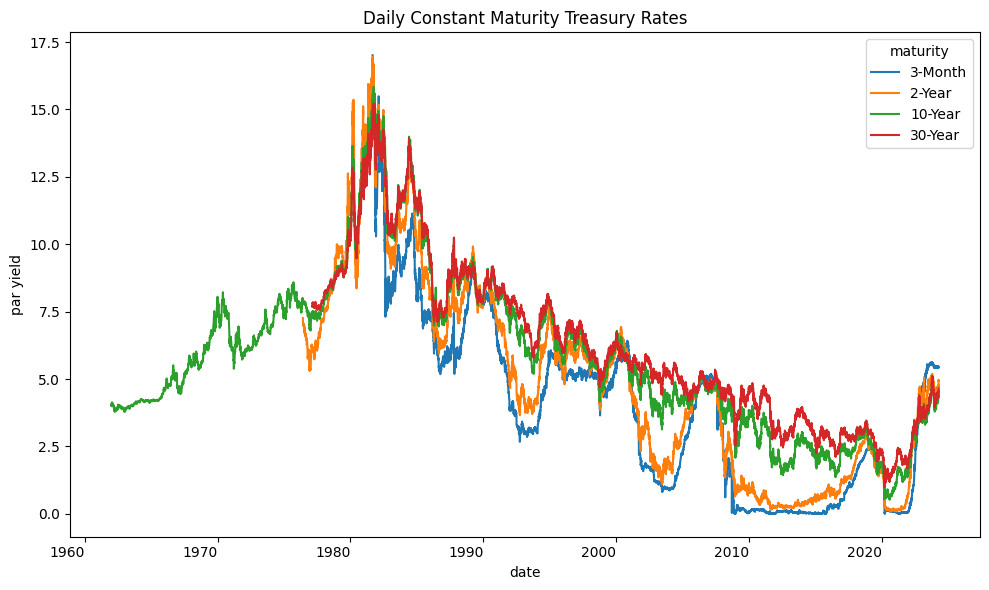

In [8]:
cols = [3, 24, 120, 360]
fig, ax = plt.subplots(figsize=(10, 6))
daily[cols].rename(columns=mapper).plot(ax=ax, rot=0)
plt.title('Daily Constant Maturity Treasury Rates')
plt.ylabel('par yield')
plt.tight_layout()

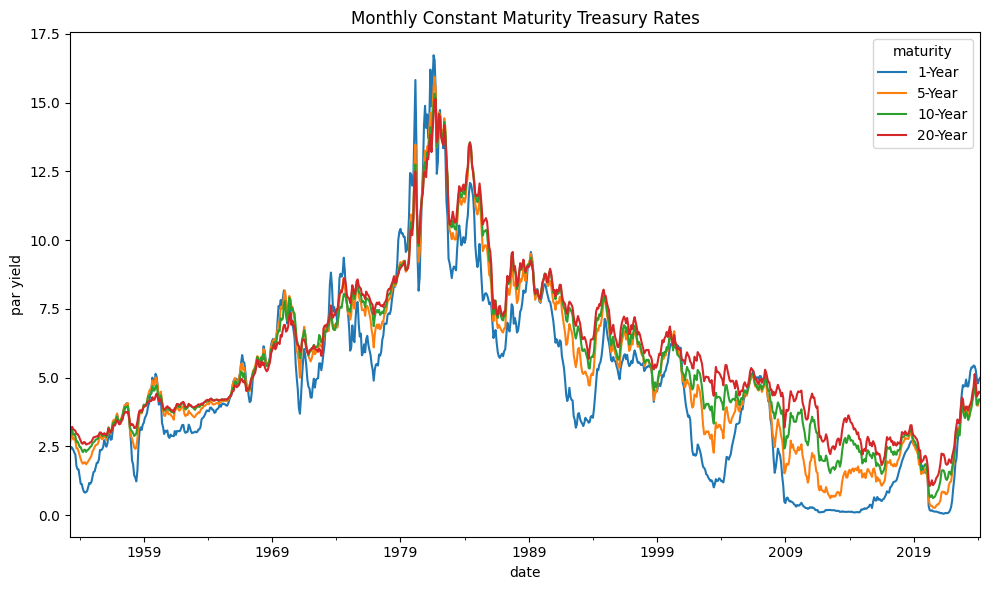

In [9]:
cols = [12, 60, 120, 240]
fig, ax = plt.subplots(figsize=(10, 6))
monthly[cols].rename(columns=mapper).plot(ax=ax, rot=0)
plt.title('Monthly Constant Maturity Treasury Rates')
plt.ylabel('par yield')
plt.tight_layout()

## Yield Curve

The Treasury's official yield curve is a par yield curve derived using
a monotone convex method. The inputs are indicative, bid-side market
price quotations (not actual transactions) for the most recently
auctioned securities obtained by the Federal Reserve Bank of New York
at or near 3:30 PM each trading day.

Historically, Treasury has used a quasi-cubic hermite spline (HS)
method for yield curve construction.  The HS method directly uses
secondary market yields as inputs to create a yield curve that is
assumed to be a par curve. The monotone convex method for deriving the
official Treasury yield curve replaced the previous quasi-cubic
hermite spline method as of December 6, 2021.

CMT yields are read directly from the Treasury's daily par yield curve
and represent "bond equivalent yields" for securities that pay
semiannual interest, which are expressed on a simple annualized basis.
These yields are not effective annualized yields or Annualized
Percentage Yields (APY), which include the effect of compounding.  To
convert a CMT yield to an APY you need to apply the standard financial
formula: APY = $(1 + y/2)^2 - 1$


### Splines

Interpolate yields at other maturies with a piecewise cubic polynomial which is twice continuously differentiable

In [10]:
yield_curve = dict()
curve_dates = sorted(daily.dropna().index[-1:0:-(5*252)])
for date in curve_dates:
    yield_curve[date] = CubicSpline(
        x=daily.columns.to_list(), y=daily.loc[date].values, bc_type='clamped')

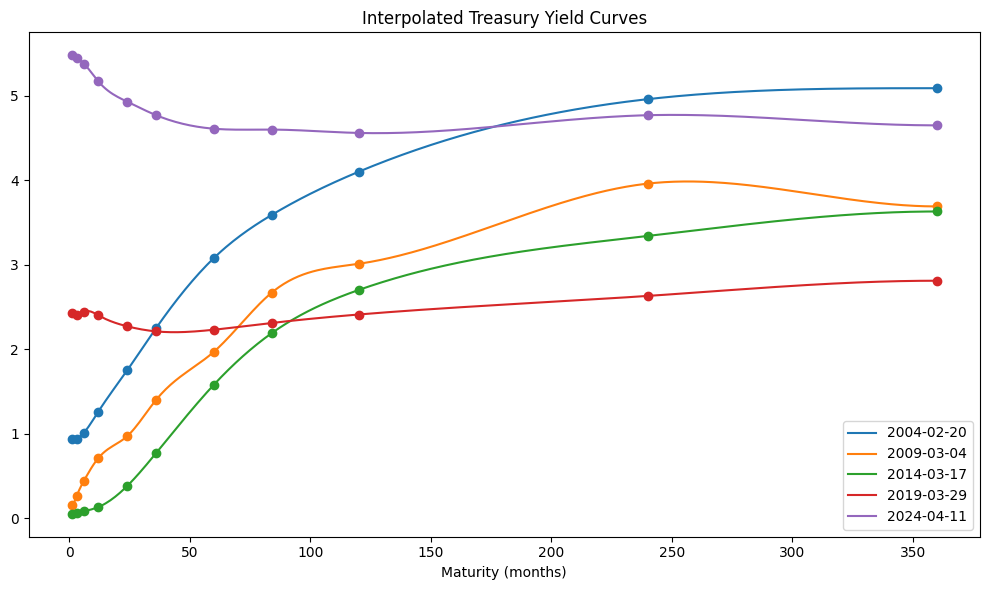

In [11]:
# Plot historical yield curves
fig, ax = plt.subplots(figsize=(10, 6))
X = list(range(1, 361))
for col, (date, curve) in enumerate(yield_curve.items()):
    ax.plot(X, curve(X), label=date.strftime('%Y-%m-%d'), color=f"C{col}")
plt.legend()
for col, (date, curve) in enumerate(yield_curve.items()):
    daily.loc[date].plot(ax=ax, marker='o', ls='', color=f"C{col}", label=None)
plt.title('Interpolated Treasury Yield Curves')
plt.xlabel('Maturity (months)')
plt.tight_layout()

## Bootstrap
This is the process of backing out spot rates by working forward and fitting zero-coupon
rates to progressively longer maturity instruments

In [12]:
# To bootstrap 6-month spot rates from 6-month par yields
m = 2   # compounding periods per year

In [13]:
# list of 6-monthly maturities
maturities = list(range(int(12/m), daily.columns[-1]+1, int(12/m)))

In [14]:
# Helper to bootstrap spot rates from par yield curve
def bootstrap_spot(coupon: float, spots: List[float], m: int, price: float=1) -> float:
    """Compute spot rate to maturity of par bond from yield and sequence of spots

    Args:
      coupon : Annual coupon rate
      spots : Simple annual spot rates each period (excluding last period before maturity
      m : Number of compounding periods per year
      price: Present value of bond

    Returns:
      Simple spot interest rate till maturity
    """
    if not spots:           # trivial one-period bond
        return coupon / price
    n = len(spots) + 1      # number of coupons through maturity

    # discount factors from given spot rates
    discount = [(1 + spot/m)**(-(1+t)) for t, spot in enumerate(spots)]

    # nominal amount of last payment
    last_payment = 1 + coupon/m
    
    # infer present value of last coupon and principal
    last_pv = price - np.sum(discount) * coupon/m 

    # compute discount factor and annualize the effective rate
    spot = ((last_payment/last_pv)**(1/n) - 1) * m
    return spot

In [15]:
# select most recent yield curve
curve_date = curve_dates[-1]
yields = [yield_curve[curve_date](t) / 100 for t in maturities]
spots = []
for coupon in yields:
    spots.append(bootstrap_spot(coupon=coupon, spots=spots, m=m))
DataFrame({curve_date.strftime('%Y-%m%d'): spots}, index=maturities).head()

,2024-0411
6,0.053800
12,0.051673
18,0.050150
24,0.049225
30,0.048370


Helper to compute bond prices

In [16]:
def bond_price(coupon: float, n: int, m: int, yields: float | List[float],
               par: float = 1) -> float:
    """Compute present value of bond given spot rates or yield-to-maturity

    Args:
      coupon : Annual coupon rate
      n : Number of remaining coupons
      m : Number of compounding periods per year
      yields : Simple annual yield-to-maturity or spot rates each period
      par : face or par value of bond

    Returns:
      Present value of bond
    """
    if not pd.api.types.is_list_like(yields):
        yields = [yields] * n        # same yield-to-maturity is spot rate every period
    assert len(yields) == n, "Number of yields must equal number of couponds"
    pv = [(1 + yields[t-1]/m)**(-t) * (coupon/m + (par if t == n else 0))
          for t in range(1, n+1)]    # discount every period's payment, plus last face
    return np.sum(pv)

In [17]:
# Sanity-check par bond price given spots
for t in range(len(yields)):
    price = bond_price(coupon=yields[t], n=t+1, m=2, yields=spots[:(t+1)])
    assert np.allclose(price, 1.0)   # discounted payments at spot rates must equal price

In [18]:
# Compute forward rates from spot rates
def forwards_from_spots(spots: List[float], m: int, skip: int=0) -> List[float]:
    """Compute forward rates given spot rates

    Args:
      spots : Sequence of simple annual spot rates
      m : Number of compounding periods per year
      skip: Number of initial periods skipped

    Returns:
      List of forward rates, excluding first period of spot rates input
    """
    result = []
    assert len(spots) >= 2, "Require at least two spot rates as input"
    for t in range(1, len(spots)):
        n = skip + t
        numerator = (1 + spots[n]/m)**n         # discounted value of period n
        denominator = (1 + spots[n-1]/m)**(n-1)   # discounter value of period n-1
        result.append(((numerator / denominator) - 1) * m)
    return result

In [19]:
forwards = [spots[0]] + forwards_from_spots(spots=spots, m=m)

Plot current yield curve

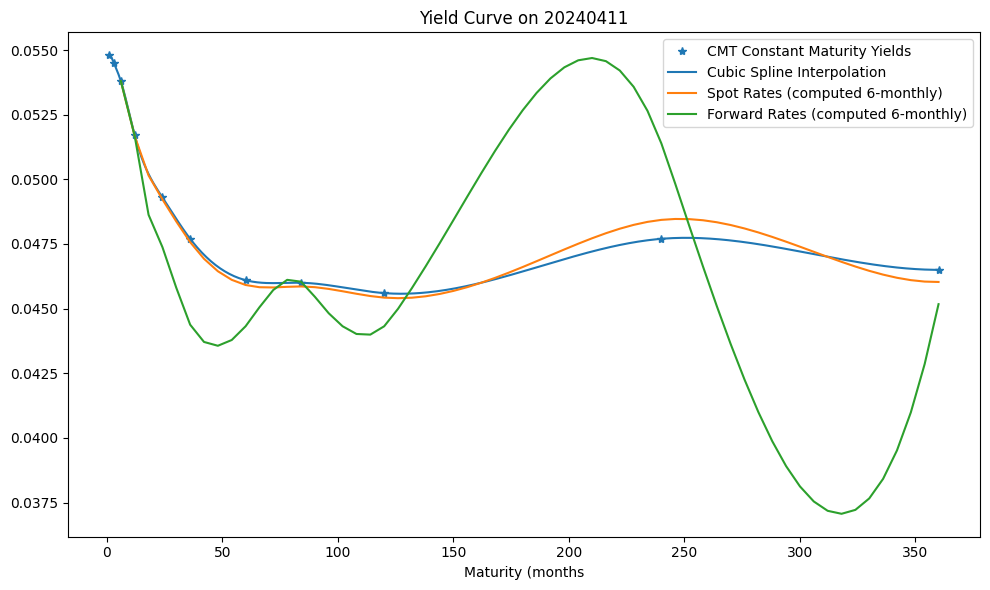

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
(daily.loc[curve_date] / 100).plot(marker='*', ls='', color="C0")
X = range(1, maturities[-1]+1)
ax.plot(X, [yield_curve[curve_date](t) / 100 for t in X], marker='', ls='-', color="C0")
ax.plot(maturities, spots, marker='', ls='-', color="C1")
ax.plot(maturities, forwards, marker='', ls='-', color="C2")
plt.legend(['CMT Constant Maturity Yields', 'Cubic Spline Interpolation',
            'Spot Rates (computed 6-monthly)', 'Forward Rates (computed 6-monthly)'])
plt.title(f"Yield Curve on {curve_date.strftime('%Y%m%d')}")
plt.xlabel('Maturity (months')
plt.tight_layout()

There are more sophisticated methods for fitting yield curves to treasuries prices


In [21]:
# Download reconstructed yield curve data by Liu and Wu (2021)
# file_id from https://sites.google.com/view/jingcynthiawu/yield-data
file_id = '15uGZet8bS5rEHy9nbGmgCHXyMGUSoHx3'   # monthly
#file_id = '15o5ahwIs-Pbaq79H4Sm0LUHGAEbCFXMs'  # daily
src = "https://drive.google.com/uc?export=download&id={}".format(file_id) # to load from gdrive
df = pd.ExcelFile(src).parse()
dates = np.where(df.iloc[:, 0].astype(str).str[0].str.isdigit())[0] # locate first date cell

In [22]:
liuwu = DataFrame(np.exp(df.iloc[dates,1:361].astype(float).values/100) - 1,
                  index=(pd.to_datetime(df.iloc[dates, 0], format="%Y%m")
                         + pd.offsets.MonthEnd(1)),
                  columns=np.arange(1, 361))

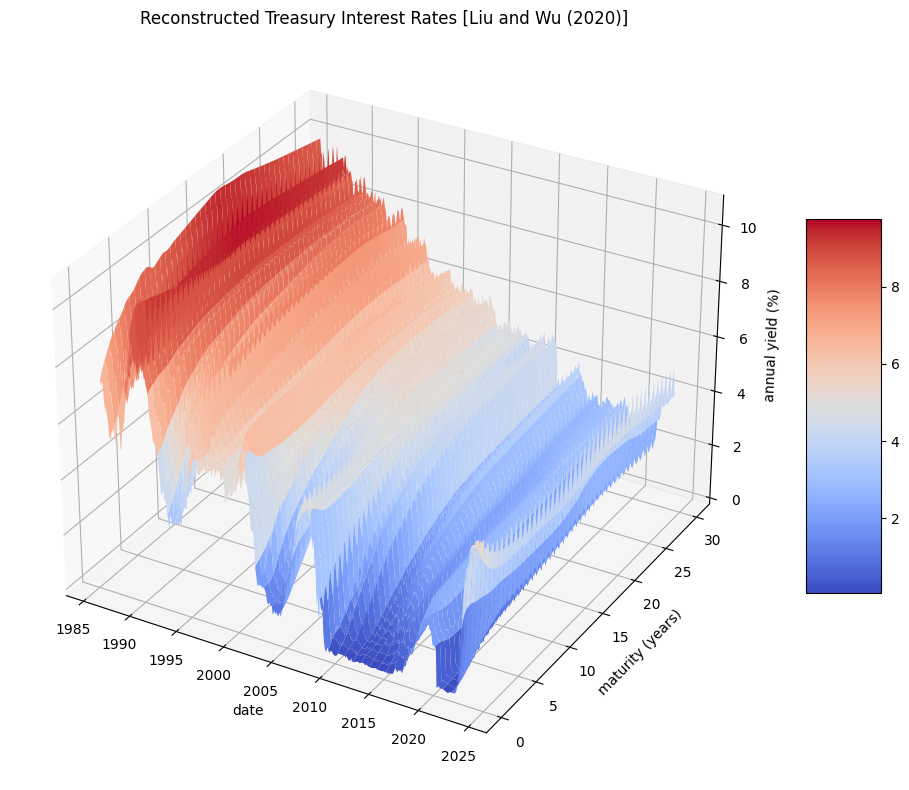

In [23]:
# Plot historical reconstructed rates as 3D surface
from mpl_toolkits.mplot3d import Axes3D
r = liuwu.dropna()
X, Y = np.meshgrid(r.index.map(lambda x: float(str(x)[:4]) + float(str(x)[5:7])/12),
                   r.columns.astype(float)/12)
#X, Y = np.meshgrid((r.index//10000) + ((((r.index//100)%100)-1)/12),
#                   r.columns.astype(float)/12)
Z = r.T.to_numpy()*100
fig = plt.figure(num=1, clear=True, figsize=(10, 8))
ax = plt.axes(projection='3d')
f = ax.plot_surface(X, Y, Z, cmap='coolwarm', linewidth=0, antialiased=True)
ax.set_title('Reconstructed Treasury Interest Rates [Liu and Wu (2020)]')
ax.set_xlabel('date')
ax.set_ylabel('maturity (years)')
ax.set_zlabel('annual yield (%)')
fig.colorbar(f, shrink=0.5, aspect=5)
plt.tight_layout()

In [24]:
# Plot historical Yield Curves
curve_dates = sorted(liuwu.index[-1:0:-(7*12)])[-4:]
for date in curve_dates:
    yield_curve[date] = CubicSpline(
        x=monthly.columns.to_list(), y=monthly.loc[date].values, bc_type='clamped')

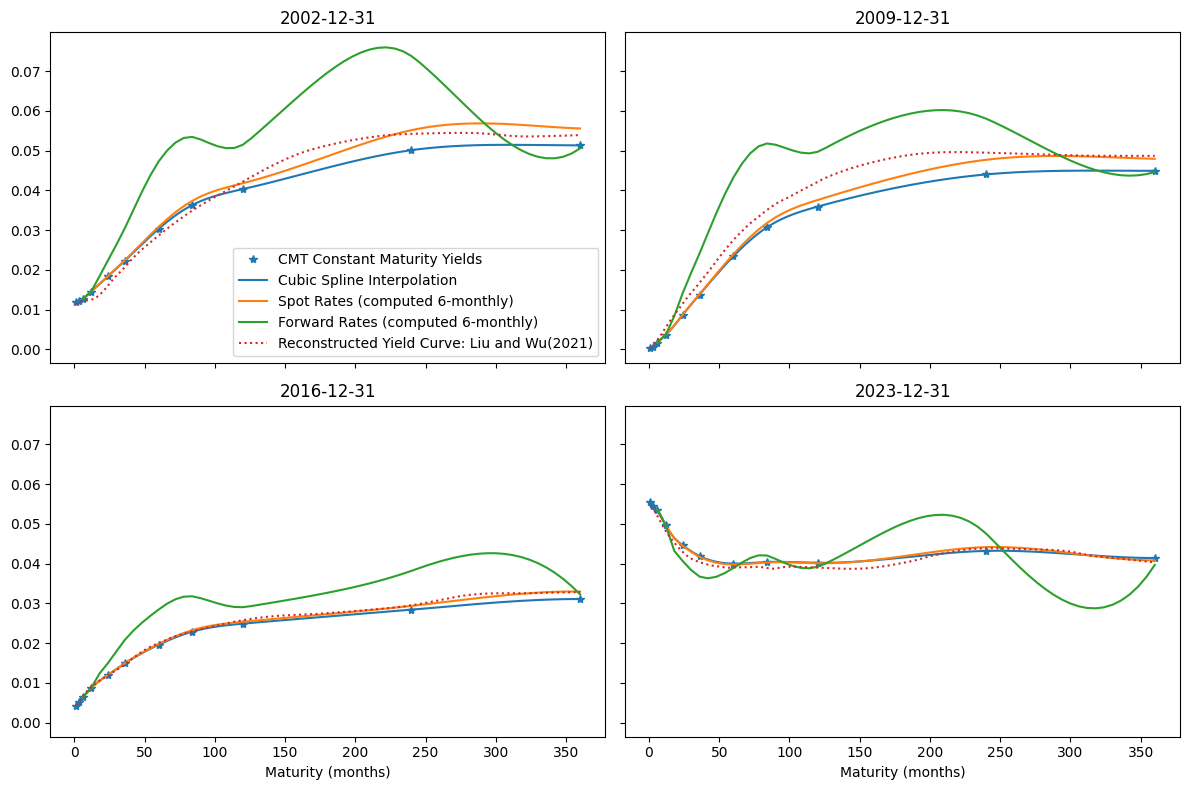

In [25]:
fig, axes = plt.subplots(2,2, figsize=(12, 8), sharey=True, sharex=True)
axes = axes.flatten()
for num, (curve_date, ax) in enumerate(zip(curve_dates, axes)):
    # fit yields
    yields = [yield_curve[curve_date](t) / 100 for t in maturities]

    # compute spots
    spots = []
    for coupon in yields:
        spots.append(bootstrap_spot(coupon=coupon, spots=spots, m=m))

    # compute forwards
    forwards = [spots[0]] + forwards_from_spots(spots=spots, m=m)    

    # plot
    (monthly.loc[curve_date] / 100).plot(marker='*', ls='', color="C0", ax=ax) # CMT yield
    X = range(1, maturities[-1]+1)
    ax.plot(X, [yield_curve[curve_date](t) / 100 for t in X], marker='', ls='-', color="C0")
    ax.plot(maturities, spots, marker='', ls='-', color="C1")
    ax.plot(maturities, forwards, marker='', ls='-', color="C2")
    liuwu.loc[curve_date].plot(ax=ax, marker='', ls=':', color="C3")   # Liu and Wu
    ax.set_title(f"{curve_date.strftime('%Y-%m-%d')}")
    ax.set_xlabel('Maturity (months)')
    if not num:
        ax.legend(['CMT Constant Maturity Yields', 'Cubic Spline Interpolation',
                   'Spot Rates (computed 6-monthly)', 'Forward Rates (computed 6-monthly)',
                   'Reconstructed Yield Curve: Liu and Wu(2021)'])
plt.tight_layout()

## Principal Component Analysis

A principal components analysis finds multiple factors and
estimates their relative importance in describing movements in the
term structure.  We carry out a principal components analysis on the
daily changes in the Constant Maturities Treasury rates.
The number of factors equals the number of rates. 

The first factor accounts for 83.7% of the variance of all daily rate movements,
while the first two account for 98.7%.  The first three factors account for 99.8% of the variance, or most of the uncertainty in interest rate movements.


In [26]:
X = daily.dropna()
Y = StandardScaler().fit_transform(X)
pca = PCA().fit(Y)
DataFrame({'Cumulative Variance Explained': pca.explained_variance_ratio_.cumsum()},
           index=[f"PC {c+1}" for c in range(pca.n_components_)])

,Cumulative Variance Explained
PC 1,0.837657
PC 2,0.986801
PC 3,0.997540
PC 4,0.998884
PC 5,0.999374
PC 6,0.999713
PC 7,0.999861
PC 8,0.999925
PC 9,0.999962
PC 10,0.999985


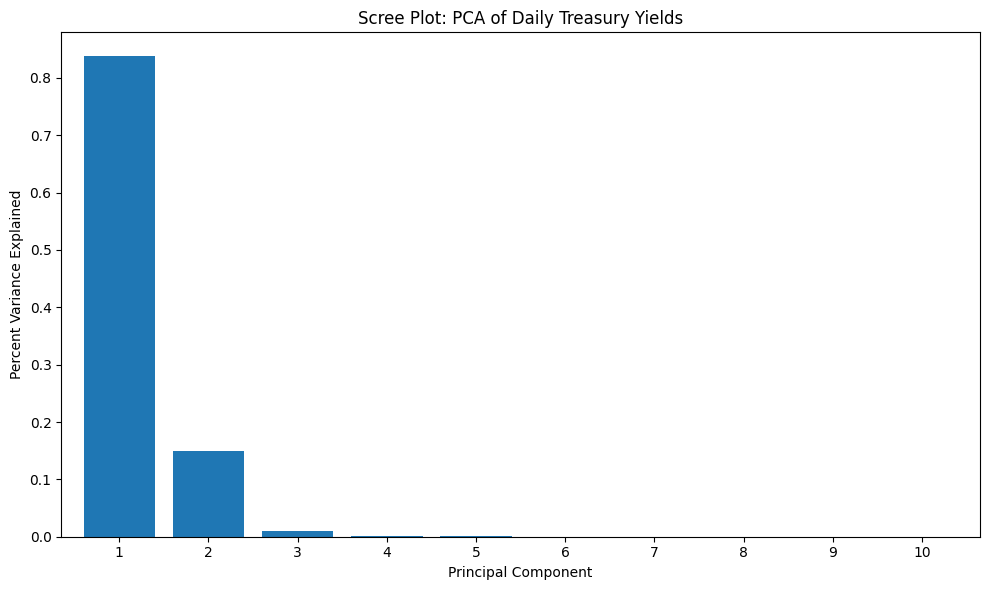

In [27]:
# Scree plot
scree = Series(pca.explained_variance_ratio_, 
               index=np.arange(1, Y.shape[1] + 1))
fig, ax = plt.subplots(figsize=(10, 6))
scree[:10].plot(kind='bar', rot=0, width=.8, ax=ax)
ax.set_title('Scree Plot: PCA of Daily Treasury Yields')
ax.set_ylabel("Percent Variance Explained")
ax.set_xlabel("Principal Component")
plt.tight_layout()

Text(0, 0.5, 'Factor Loading')

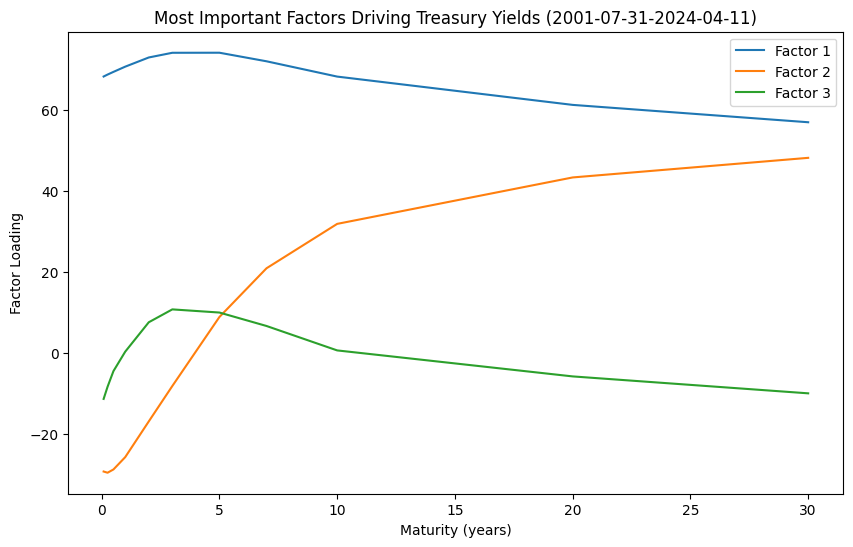

In [28]:
# Factor Loadings
Z = pca.components_[:3, :].T * pca.singular_values_[:3].reshape(1, 3)
loadings = DataFrame(Z, columns=[f"Factor {n+1}" for n in range(3)], index=X.columns/12)
fig, ax = plt.subplots(figsize=(10, 6))
loadings.plot(ax=ax)
ax.set_title(f"Most Important Factors Driving Treasury Yields"
             f" ({str(X.index[0])[:10]}-{str(X.index[-1])[:10]})")
ax.set_xlabel('Maturity (years)')
ax.set_ylabel('Factor Loading')

Most important factors driving treasury yields:

- Factor 1 is a shift in the "level" of the term structure where all
  rates move in the same direction by approximately (but not exactly)
  the same amount.

- Factor 2 is a shift in the "slope" where short-term rates move in
  one direction and long-term rates move in the other direction. It
  corresponds to steepening or flattening of the term structure.

- Factor 3 is a shift in the "twist" of the term structure, where
  relatively short-term and relatively long-term rates move in one
  direction while intermediate rates move in the other direction


## Singular Value Decomposition

Intuitively, PCA (also called eigendecomposition) is a rotation of
the cloud of data points in Euclidean space where the co-ordinate axes
are chosen such that each successive axis captures as much variance as
possible.

Singular Value Decomposition (SVD) of a matrix is a factorization of that
matrix into a product three matrices, which can be interpreted as a
rotation, followed by a rescaling, followed by another rotation: $A = U S V^T$.

The singular value decomposition of a data matrix $A$ is a
generalizaton of an eigendecomposition of the square symmetric matrix:
$A^TA = V \Lambda V^T$.

A goal of both PCA and SVD is to approximate the original data matrix with a lower-dimensional presentation, with the most important eigen- and singular vectors associated with the largest eigenvalues and singular values respectively.


In [29]:
# A is num_samples (N) by num_features (K) data matrix, standardized by column
A = daily.dropna().values
A = (A - A.mean(axis=0)) / A.std(axis=0)  # subtract mean, divide by std
N, K = A.shape
A.shape

(5677, 11)

In [30]:
# svd x is related to pca of x'x
u, s, vT = np.linalg.svd(A, full_matrices=False)
v = vT.T   # transposed right singular vector was returned

The __eigenvalues__ ($\lambda$) of PCA
- can be retrieved as (N-1) times pca.explained_variance_
- are equal to the squares of the singular values ($s$ from SVD)


In [31]:
# s**2 = lambda = N * explained_variance
assert np.allclose((N-1) * pca.explained_variance_, s**2), 'eigenvalues values'
assert np.allclose(pca.singular_values_, s), "singular values"

The __components__  (columns of $V$) of an eigendecomposition
- are also called the __eigenvectors__, or right __singular vectors__ from the SVD
- can be retrieved from the rows of pca.components_, or
- are the rows of $V^T$ (identically, the columns of $V$ from SVD)

Relatedly:
- __loadings__ are computed by multiplying each component by its
  corresponding singular value $v \cdot s$


In [32]:
# components and right singular vectors are identical up to sign flip
for pc in range(K):
    assert (np.allclose(vT[pc, :], pca.components_[pc, :]) or
            np.allclose(vT[pc, :], -pca.components_[pc, :]))

In [33]:
# square of loadings is same as square of data matrix, i.e. the covariance matrix
loadings = np.diag(pca.singular_values_) @ pca.components_
assert np.allclose(A.T @ A, loadings.T @ loadings), 'square matrix'

The __projections__ of PCA
- are also known as the __scores__ or __co-ordinates__
- are computed by projecting the data matrix on the components $A \cdot V$
- or by scaling each left singular vector by its corresponding singular value $u \cdot s$
- can be retrieved by calling pca.transform() on the data matrix


In [34]:
# assert: x @ v == transform(x) (aka projection on components)
y = pca.transform(A)
for pc in range(K):
    assert np.allclose((A@v)[:,pc], -y[:,pc]) or np.allclose((A@v)[:,pc], y[:,pc])
    assert np.allclose(u[:,pc]*s[pc], -y[:,pc]) or np.allclose(u[:,pc]*s[pc], y[:,pc])

Low-rank approximation by PCA: $A'A \approx V D V'$


In [35]:
ATA = A.T.dot(A)
eigval, eigvec = (N-1)*pca.explained_variance_, pca.components_.T
assert np.allclose(eigvec.dot(np.diag(eigval)).dot(eigvec.T), ATA), "pca error"

In [36]:
print('rank-K PCA approximation:')
DataFrame.from_dict({k: (la.norm(
    eigvec[:, :k].dot(np.diag(eigval[:k])).dot(eigvec[:, :k].T) - ATA)/la.norm(ATA)) 
    for k in range(1, 5)}, orient='index', columns=['Frobenius Norm'])\
    .rename_axis(index='K')

rank-K PCA approximation:


,Frobenius Norm
K,
1,0.175740
2,0.012739
3,0.001739
4,0.000728


Low-rank approximation by SVD: $A \approx U S V'$


In [37]:
assert np.allclose(u.dot(np.diag(s)).dot(v.T), A), "svd error"

In [38]:
print('rank-K SVD approximation:')
DataFrame.from_dict({k: la.norm(
    u[:, :k].dot(np.diag(s[:k])).dot(v[:, :k].T) - A) / la.norm(A)
    for k in range(1, 5)}, orient='index', columns=['Frobenius Norm'])\
    .rename_axis(index='K')

rank-K SVD approximation:


,Frobenius Norm
K,
1,0.402918
2,0.114886
3,0.049601
4,0.033414
